In [90]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
from skimage.io import imread
import cv2
import tensorflow as tf

%matplotlib inline
plt.style.use('default')

In [91]:
def bgr2rgb(img_BGR):
    b,g,r = cv2.split(img_BGR)
    img_RGB = cv2.merge((r,g,b))
    return img_RGB

Prueba de procesamiento de imágenes

In [3]:
#imageA = cv2.imread('Data/clips-data/train/clips-30003.png')

In [3]:
#Remover la imagen
def remover_lineas(imagen):
    azul_i = np.array([118, 0, 0], np.uint8)  #Límites para el umbral de colores
    azul_f = np.array([180, 255, 255], np.uint8)

    img_trans = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)
    img_HSV = cv2.cvtColor(img_trans, cv2.COLOR_BGR2HSV) #Transformamos al formato HSV
    mask = cv2.inRange(img_HSV,azul_i,azul_f) #Aplicamos el umbral para crear la máscara
    img_masked = cv2.bitwise_and(imagen,imagen,mask=mask) #Filtramos con la máscara
    img_masked[mask==0]=[255,255,255]  #Los píxeles negros (valor = 0) los pintamos como blancos (valor = 255)
    
    mask_inv = cv2.bitwise_not(mask) #Invertimos la máscara (imagen 3)
    new_img = cv2.inpaint(img_masked,mask_inv,1,cv2.INPAINT_TELEA)  #Pintamos los píxeles de la máscara con los píxeles de alrededor
    return new_img

#Invertir el color de la imagen
def invertir_img(imagen):
    img_grayScale = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)  #Convertimos la imagen rgb a escala de grises
    inverted_image = cv2.bitwise_not(img_grayScale) #Invertimos los colores de la escala de grises, los blancos pasan a ser negros
    return inverted_image

Leemos los csv con los valores del target (y)

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train
y_train = df_train['clip_count']

In [6]:
df_test
y_test = df_test['clip_count']

In [8]:
type(df_test.iloc[0,0])

numpy.int64

Cargamos las imágenes

In [7]:
path_train = 'Data/clips-data/train'
path_test = 'Data/clips-data/test'
path_sol = 'Data/clips-data/solution'

In [8]:
def read_data(path):
    X = []
    names = []
    for img in os.listdir(path):
        # image = imread(path + '/' + img)
        image = cv2.imread(path+"/"+img)
        img_masked = invertir_img(remover_lineas(image))
        smallimage = cv2.resize(img_masked, (96,96))
        X.append(smallimage)  # X: images
        name = img.split('-')[1]
        names.append(int(name.split('.')[0])) #names of img
    return np.array(X),np.array(names)

In [9]:
X_train,names_train = read_data(path_train)
X_test,names_test = read_data(path_test)
X_sol,names_sol = read_data(path_sol)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(X_sol.shape)

(15000, 96, 96)
(3000, 96, 96)
(2000, 96, 96)


In [13]:
X_train[0,:,:]

array([[ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ..., 10, 77, 54],
       [ 0,  0,  0, ..., 68, 35, 60],
       ...,
       [ 0,  0,  0, ..., 87, 83,  0],
       [ 1,  1,  1, ...,  3, 18, 95],
       [ 1,  1,  1, ...,  1,  1,  2]], dtype=uint8)

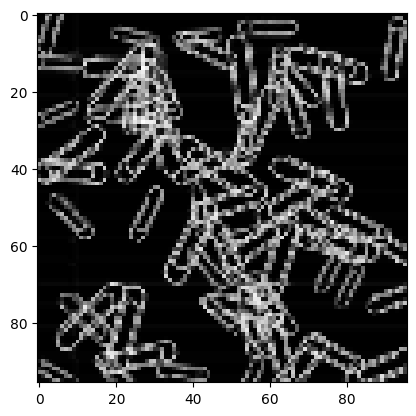

In [14]:
prueba = X_train[5]
plt.imshow(prueba,cmap='gray');

In [15]:
print(np.max(X_train))
print(np.min(X_train))

131
0


In [21]:
#Normalizamos los datos:
X_train_Norm = X_train.astype("float32")/255
X_test_Norm = X_test.astype("float32")/255
X_sol_Norm = X_sol.astype("float32")/255

In [22]:
y_train_float = y_train.astype("float32")
y_test_float = y_test.astype("float32")

Modelo

In [17]:
from tensorflow import keras


In [19]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [20]:
from keras.callbacks import ModelCheckpoint
mcheckpoint = ModelCheckpoint("callback_model1.h5")

In [21]:
X_train_Norm[0].shape

(96, 96)

In [22]:
X_train_Norm.shape

(15000, 96, 96)

In [23]:
#Modificamos la dimension para que las imágenes sean 96x96x1
X_train_dim = np.expand_dims(X_train_Norm,3)
X_test_dim = np.expand_dims(X_test_Norm,3)
X_sol_dim = np.expand_dims(X_sol_Norm,3)
print(X_train_dim.shape)

(15000, 96, 96, 1)


In [24]:
X_train_dim[0].shape

(96, 96, 1)

Creación del modelo

In [25]:
#    keras.optimizers.Adadelta(),
#    keras.optimizers.Adagrad(),
#    keras.optimizers.Adam(),
#    keras.optimizers.Adamax(),
#    #keras.optimizers.Ftrl(),
#    keras.optimizers.Nadam(),
#    keras.optimizers.RMSprop(),

In [77]:
optimizers_list = [

    keras.optimizers.Adam(),
    keras.optimizers.Adamax(),
    
]

In [25]:
capas = [
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape =X_train_dim[0].shape),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 300, activation='relu'),
    keras.layers.Dense(units = 100, activation='relu'),
    #keras.layers.Dense(units = 32, activation='relu'),
    keras.layers.Dense(units = 1, activation='relu')
]



In [86]:
#FUNCION CREADA PARA LA LIBRERIA

def check_optimizadores (modelo, optimizadores, epochs, loss, metrics, x_data, y_data, bath, callbks):
    print ('entro')
    
    results = {}
    history = {}

    for optimizadores in optimizadores:
    
  
    
        modelo.compile (loss = loss, optimizer= optimizadores, metrics = metrics)
        optimizer_key = str(type(optimizadores).__name__)
        history[optimizer_key] = modelo.fit(x_data, y_data, batch_size = bath, epochs = epochs, validation_split = 0.2,callbacks= callbks)
        results[optimizer_key] = {}
        results[optimizer_key]['loss'] = history[optimizer_key].history['loss'][epochs -1]
        results[optimizer_key]['val_loss'] = history[optimizer_key].history['val_loss'][epochs -1]
        
        df_results = pd.DataFrame(results)
    graf_df_result = df_results.plot.bar()
    
    graf_epoc = plt.figure(figsize= (7,7))
    plt.xlabel ('Epoch')
    plt.ylabel('Loss')
    
    for optimizadores in history:
        hist = pd.DataFrame(history[optimizadores].history)
        
        plt.plot(history[optimizadores].epoch, np.array(hist['loss']),
                label = 'Train loss' + optimizadores)
        plt.plot(history[optimizadores].epoch, np.array(hist['val_loss']),
                label = 'Val loss' + optimizadores)
    plt.legend()
    
    return graf_df_result, graf_epoc

In [87]:
# PRUEBA DE LA FUNCION CREADA
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [88]:
model = model = keras.Sequential(capas)

In [92]:
type (model)

keras.engine.sequential.Sequential

entro
Epoch 1/5
94/94 [==============================] - 83s 883ms/step - loss: 3.5275 - root_mean_squared_error: 1.8782 - val_loss: 4.3009 - val_root_mean_squared_error: 2.0739
Epoch 2/5
94/94 [==============================] - 85s 904ms/step - loss: 3.0121 - root_mean_squared_error: 1.7355 - val_loss: 4.3030 - val_root_mean_squared_error: 2.0744
Epoch 3/5
94/94 [==============================] - 85s 902ms/step - loss: 3.4278 - root_mean_squared_error: 1.8514 - val_loss: 4.1851 - val_root_mean_squared_error: 2.0458
Epoch 4/5
94/94 [==============================] - 81s 865ms/step - loss: 2.7091 - root_mean_squared_error: 1.6459 - val_loss: 4.5414 - val_root_mean_squared_error: 2.1311
Epoch 5/5
94/94 [==============================] - 82s 869ms/step - loss: 2.7410 - root_mean_squared_error: 1.6556 - val_loss: 4.1468 - val_root_mean_squared_error: 2.0364
Epoch 1/5
94/94 [==============================] - 82s 871ms/step - loss: 2.2353 - root_mean_squared_error: 1.6179 - val_loss: 4.4106 

(<AxesSubplot:>, <Figure size 700x700 with 1 Axes>)

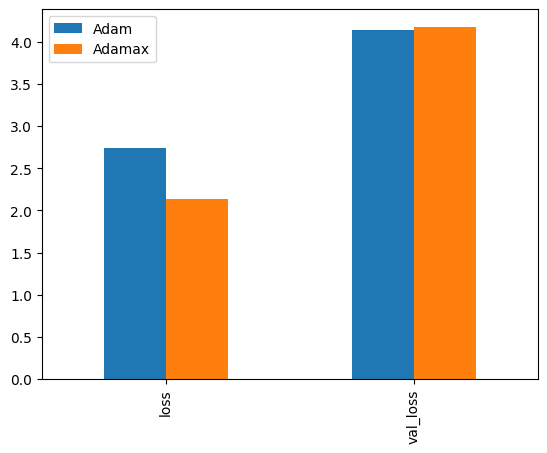

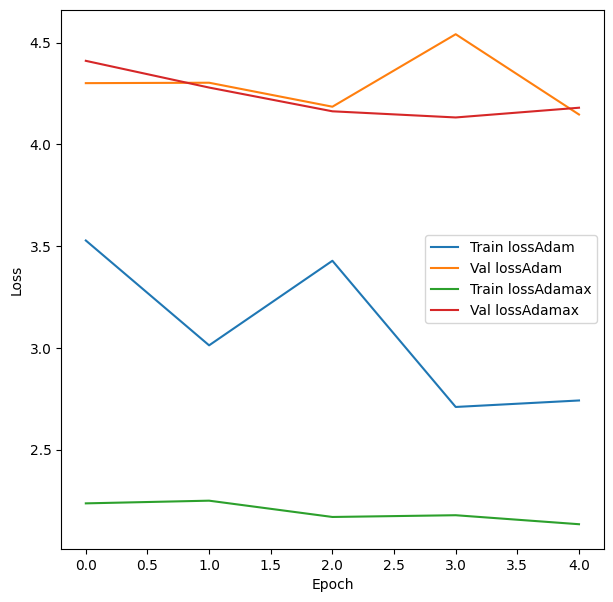

In [89]:
#PRUEBA DE LA FUNCION CREADA
check_optimizadores (model, optimizers_list, 5, "mean_squared_error",  keras.metrics.RootMeanSquaredError(), X_train_dim, y_train_float, int(128), earlystop)

**Adam**

In [27]:
model.compile(
    optimizer = tf.keras.optimizers.Adamax(), #(learning_rate=.2),   #en lugar de "sgd",
    loss = "mean_squared_error",
    metrics = [keras.metrics.RootMeanSquaredError()]
    )

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

Entrenamiento

In [29]:
history = model.fit(X_train_dim,
                   y_train_float,
                   batch_size = 128,
                   epochs = 12,
                   callbacks = [earlystop, mcheckpoint],
                   )

Epoch 1/12
118/118 [==============================] - 116s 968ms/step - loss: 151.5308 - root_mean_squared_error: 12.3098
Epoch 2/12
118/118 [==============================] - 116s 979ms/step - loss: 31.2187 - root_mean_squared_error: 5.5874
Epoch 3/12
118/118 [==============================] - 117s 987ms/step - loss: 13.6283 - root_mean_squared_error: 3.6917
Epoch 4/12
118/118 [==============================] - 118s 1s/step - loss: 12.0553 - root_mean_squared_error: 3.4721
Epoch 5/12
118/118 [==============================] - 112s 951ms/step - loss: 11.3584 - root_mean_squared_error: 3.3702
Epoch 6/12
118/118 [==============================] - 112s 949ms/step - loss: 10.6069 - root_mean_squared_error: 3.2568
Epoch 7/12
118/118 [==============================] - 112s 948ms/step - loss: 9.9497 - root_mean_squared_error: 3.1543
Epoch 8/12
118/118 [==============================] - 115s 977ms/step - loss: 9.7998 - root_mean_squared_error: 3.1305
Epoch 9/12
118/118 [=======================

In [30]:
rmse_test = model.evaluate(X_test_dim, y_test_float)
print(rmse_test)

94/94 [==============================] - 8s 87ms/step - loss: 11.4305 - root_mean_squared_error: 3.3809
[11.430458068847656, 3.3808960914611816]


In [31]:
pred_test = model.predict(X_test_dim)
print(pred_test.round(0))

[[69.]
 [47.]
 [45.]
 ...
 [50.]
 [58.]
 [44.]]


In [32]:
y_test_float

0       68.0
1       40.0
2       41.0
3       39.0
4       19.0
        ... 
2995     9.0
2996    45.0
2997    52.0
2998    63.0
2999    43.0
Name: clip_count, Length: 3000, dtype: float32

In [33]:
#Con 5>10 epochs
pred1 = model.predict(X_sol_dim)
print(pred1.round(0))

[[31.]
 [28.]
 [37.]
 ...
 [74.]
 [23.]
 [38.]]


In [34]:
#pred_test2 = model.predict(X_test_dim)
#print(pred_test2.round(0))

In [35]:
sol_test = pd.DataFrame(y_test_float)
sol_test['10 epochs'] = pred_test.round(0)

sol_test

,clip_count,10 epochs
0,68.0,69.0
1,40.0,47.0
2,41.0,45.0
3,39.0,39.0
4,19.0,17.0
...,...,...
2995,9.0,10.0
2996,45.0,53.0
2997,52.0,50.0
2998,63.0,58.0


In [36]:
#Solution 5>10 epochs
solution7 = pd.DataFrame(names_sol,columns=['id'])
solution7['clip_count'] = pred1.round(0).astype(int)
solution7

,id,clip_count
0,48001,31
1,48002,28
2,48003,37
3,48004,13
4,48005,42
...,...,...
1995,49996,36
1996,49997,54
1997,49998,74
1998,49999,23


In [37]:
solution7.to_csv('solution7.csv',index=False)

In [38]:
prueba_df = pd.read_csv('solution7.csv')
prueba_df

,id,clip_count
0,48001,31
1,48002,28
2,48003,37
3,48004,13
4,48005,42
...,...,...
1995,49996,36
1996,49997,54
1997,49998,74
1998,49999,23
